Purpose:

Explore and visualize the behavior of “big moves”. The goal is understanding patterns rather than model accuracy.

What We Did:

We defined big moves based on next-day returns relative to 20-day volatility, then built supporting features from returns, volatility, variance controls, and social mentions. The notebook focuses on visual analysis, including:
Scatter of return vs volatility,
Daily spike rate and 14-day trend,
Per-ticker spike frequency,
Mentions-decile vs spike rate patterns,
Event raster showing when and which tickers spiked,
Threshold sensitivity overview.
It also includes a light comparison of Logistic and Random-Forest models (with SMOTE and 80/20 time split) to show the difficulty of predicting these rare events.

Conclusion:

Big moves during high-volatility and are rare/uneven across tickers. Across the exploratory plots, volatility drives most structure; mention features show weak or inconsistent separation, acting more reactive than predictive. The real value of this notebook is the visual diagnostics that explain when and where big moves occur.

In [29]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve,
                             precision_recall_curve, confusion_matrix, f1_score)

from imblearn.over_sampling import SMOTE
import os
import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import f1_score


In [30]:


import matplotlib.pyplot as plt

ROLL_WIN = int(os.getenv("ROLL_WIN", 20))   # rolling window for volatility
K_SIGMA  = float(os.getenv("K_SIGMA", 1.5)) # threshold multiplier

DATA_DIR = Path(os.getenv("DATA_DIR", "/users/nihan/Desktop/Erdos_FinanceProject/classification"))
DATA_STOCK    = DATA_DIR / os.getenv("DATA_STOCK", "bluesky_stock_merged.csv")
DATA_MENTIONS = DATA_DIR / os.getenv("DATA_MENTIONS", "bluesky_merged_mentions.csv")
DATA_CONTROLS = DATA_DIR / os.getenv("DATA_CONTROLS", "control_sa.csv")

OUT_DATASET = DATA_DIR / "movement_threshold_dataset_smote_xgb.csv"
OUT_RESULTS = DATA_DIR / "model_results_smote_xgb.csv"
OUT_ROC_PNG = DATA_DIR / "roc_comparison_smote_xgb.png"

MENTION_COLS = ["all_keywords_mentions","ticker_mentions","ceo_mentions"]


In [31]:

def safe_read_csv(path: Path) -> pd.DataFrame:
    if path.exists():
        return pd.read_csv(path)
    print(f"[WARN] Missing file: {path} — continuing without it.")
    return pd.DataFrame()

def ensure_mention_cols(df: pd.DataFrame) -> pd.DataFrame:
    for c in MENTION_COLS:
        if c not in df.columns:
            df[c] = 0
    return df

def build_dataset():
    stock = safe_read_csv(DATA_STOCK)
    assert not stock.empty, f"Cannot proceed: {DATA_STOCK} is missing or empty."
    stock["Date"] = pd.to_datetime(stock["Date"])

    mentions = safe_read_csv(DATA_MENTIONS)
    if not mentions.empty:
        if "date" in mentions.columns:
            mentions["date"] = pd.to_datetime(mentions["date"])
            mentions = mentions.rename(columns={"date": "Date"})
        elif "Date" in mentions.columns:
            mentions["Date"] = pd.to_datetime(mentions["Date"])
        else:
            print("[WARN] Mentions has no date column; skipping merge.")
            mentions = pd.DataFrame()

    controls = safe_read_csv(DATA_CONTROLS)

    df = stock.copy()
    if not mentions.empty and {"company","Date"}.issubset(mentions.columns) and "company" in df.columns:
        keep = ["company","Date"] + [c for c in MENTION_COLS if c in mentions.columns]
        keep = [c for c in keep if c in mentions.columns]
        df = df.merge(mentions[keep], on=["company","Date"], how="left")
    else:
        print("[INFO] Mentions merge skipped or partial; filling missing mention columns with zeros.")
    df = ensure_mention_cols(df)

    if not controls.empty and "Ticker" in controls.columns:
        df = df.merge(controls, on="Ticker", how="left", suffixes=("","_ctrl"))

    # Target construction
    df = df.sort_values(["Ticker","Date"]).reset_index(drop=True)
    df["log_ret_t"]   = df["log_return"]
    df["log_ret_tp1"] = df.groupby("Ticker")["log_return"].shift(-1)
    df["roll_std_20"] = df.groupby("Ticker")["log_ret_t"].transform(
        lambda s: s.rolling(ROLL_WIN, min_periods=20).std()
    )
    df["label_big_move"] = (df["log_ret_tp1"].abs() >= (K_SIGMA * df["roll_std_20"])).astype(int)

    # Feature engineering
    for col in MENTION_COLS:
        df[f"{col}_lag1"] = df.groupby("Ticker")[col].shift(1)
        df[f"{col}_chg1"]  = df[col] - df[f"{col}_lag1"]

    df["ret_lag1"] = df.groupby("Ticker")["log_ret_t"].shift(1)
    df["ret_lag5"] = df.groupby("Ticker")["log_ret_t"].shift(5)
    df["ret_ma5"]  = df.groupby("Ticker")["log_ret_t"].transform(lambda s: s.rolling(5, min_periods=3).mean())
    df["ret_std5"] = df.groupby("Ticker")["log_ret_t"].transform(lambda s: s.rolling(5, min_periods=3).std())

    df_model = df.dropna(subset=["log_ret_tp1","roll_std_20"]).copy()

    candidate_feats = [
        "all_keywords_mentions","ticker_mentions","ceo_mentions",
        "all_keywords_mentions_chg1","ticker_mentions_chg1","ceo_mentions_chg1",
        "ret_lag1","ret_lag5","ret_ma5","ret_std5",
        "roll_std_20",
        "weekly_variance","monthly_variance",
        "weekly_variance_ctrl","pct_change","monthly_variance_ctrl"
    ]
    feature_cols = [c for c in candidate_feats if c in df_model.columns]

    return df_model, feature_cols



TRAIN  big / none: 1389 6979
TEST   big / none: 287 1790

=== Logistic (SMOTE) ===
              precision    recall  f1-score   support

           0      0.876     0.831     0.853      1790
           1      0.203     0.268     0.231       287

    accuracy                          0.753      2077
   macro avg      0.540     0.550     0.542      2077
weighted avg      0.783     0.753     0.767      2077

ROC-AUC: 0.649 | F1 (positive): 0.231 | F1 (macro): 0.542
Confusion matrix:
 [[1488  302]
 [ 210   77]]

=== RandomForest (SMOTE) ===
              precision    recall  f1-score   support

           0      0.879     0.917     0.898      1790
           1      0.294     0.216     0.249       287

    accuracy                          0.820      2077
   macro avg      0.587     0.566     0.573      2077
weighted avg      0.799     0.820     0.808      2077

ROC-AUC: 0.686 | F1 (positive): 0.249 | F1 (macro): 0.573
Confusion matrix:
 [[1641  149]
 [ 225   62]]

=== XGBoost (SMOTE) ===


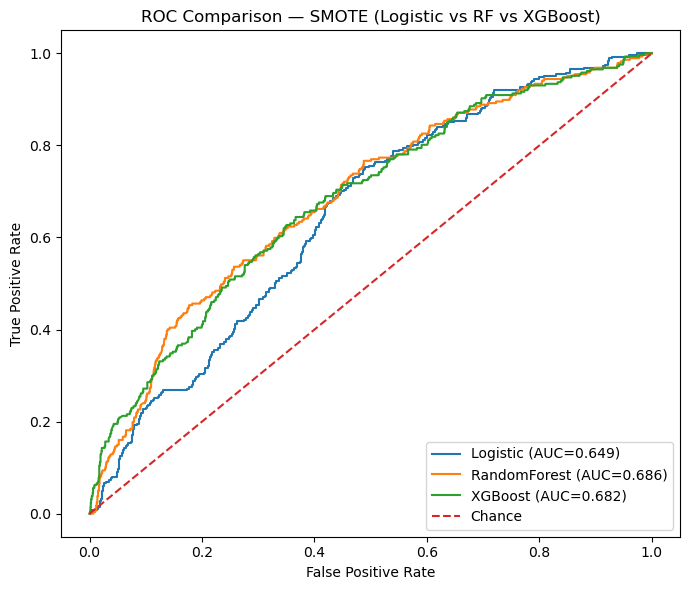


Best model: XGBoost (ROC-AUC=0.682, F1_Positive=0.311)
Saved dataset: /users/nihan/Desktop/Erdos_FinanceProject/classification/movement_threshold_dataset_smote_xgb.csv
Saved results table: /users/nihan/Desktop/Erdos_FinanceProject/classification/model_results_smote_xgb.csv
Saved ROC plot: /users/nihan/Desktop/Erdos_FinanceProject/classification/roc_comparison_smote_xgb.png


In [32]:

def main():
    df_model, feature_cols = build_dataset()

    X = df_model[feature_cols].copy()
    y = df_model["label_big_move"].astype(int).copy()

    cutoff_date = df_model["Date"].quantile(0.80)
    train_idx   = df_model["Date"] <= cutoff_date
    test_idx    = df_model["Date"] >  cutoff_date

    train_big = df_model[train_idx & (df_model["label_big_move"] == 1)]
    train_none= df_model[train_idx & (df_model["label_big_move"] == 0)]
    test_big  = df_model[test_idx  & (df_model["label_big_move"] == 1)]
    test_none = df_model[test_idx  & (df_model["label_big_move"] == 0)]

    print("TRAIN  big / none:", len(train_big), len(train_none))
    print("TEST   big / none:", len(test_big),  len(test_none))

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]

    X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]

    # Scale
    scaler = StandardScaler(with_mean=False)
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # SMOTE
    sm = SMOTE(random_state=42, sampling_strategy=0.5)
    X_train_res, y_train_res = sm.fit_resample(X_train_s, y_train)

    # Models
    models = {
        "Logistic": LogisticRegression(max_iter=3000, n_jobs=1),
        "RandomForest": RandomForestClassifier(
            n_estimators=300, max_depth=None, min_samples_split=4, min_samples_leaf=2,
            n_jobs=-1, random_state=42),
        "XGBoost":XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1,
            tree_method="hist"  # fast & safe default
        )
    }

    results = []
    roc_curves = []

    for name, model in models.items():
        model.fit(X_train_res, y_train_res)
        yhat = model.predict(X_test_s)
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_test_s)[:,1]
        else:
            # Fallback: decision_function → map to [0,1] with min-max (rarely needed here)
            if hasattr(model, "decision_function"):
                s = model.decision_function(X_test_s)
                proba = (s - s.min()) / (s.max() - s.min() + 1e-9)
            else:
                proba = np.zeros_like(yhat, dtype=float)

        auc = roc_auc_score(y_test, proba)
        f1_pos = f1_score(y_test, yhat, pos_label=1)
        f1_macro = f1_score(y_test, yhat, average='macro')

        print(f"\n=== {name} (SMOTE) ===")
        print(classification_report(y_test, yhat, digits=3))
        print(f"ROC-AUC: {auc:.3f} | F1 (positive): {f1_pos:.3f} | F1 (macro): {f1_macro:.3f}")
        print("Confusion matrix:\n", confusion_matrix(y_test, yhat))

        fpr, tpr, _ = roc_curve(y_test, proba)
        roc_curves.append((name, fpr, tpr, auc))

        results.append({
            "Model": name,
            "ROC-AUC": auc,
            "F1_Positive": f1_pos,
            "F1_Macro": f1_macro
        })

    # Summary table
    result_df = pd.DataFrame(results).sort_values("F1_Positive", ascending=False)
    print("\n=== MODEL COMPARISON TABLE (sorted by F1_Positive) ===")
    print(result_df.to_string(index=False))
    result_df.to_csv(OUT_RESULTS, index=False)

    # Save dataset for reproducibility
    keep_cols = ["Date","Ticker","company","log_ret_tp1","roll_std_20","label_big_move"] + feature_cols
    df_model[keep_cols].to_csv(OUT_DATASET, index=False)

    # Combined ROC plot
    plt.figure(figsize=(7,6))
    for name, fpr, tpr, auc in roc_curves:
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],'--', label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Comparison — SMOTE (Logistic vs RF vs XGBoost)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(OUT_ROC_PNG, dpi=150)
    plt.show()

    # Best model (by F1_Positive)
    best_row = result_df.iloc[0]
    print(f"\nBest model: {best_row['Model']} "
          f"(ROC-AUC={best_row['ROC-AUC']:.3f}, F1_Positive={best_row['F1_Positive']:.3f})")
    print(f"Saved dataset: {OUT_DATASET}")
    print(f"Saved results table: {OUT_RESULTS}")
    print(f"Saved ROC plot: {OUT_ROC_PNG}")

if __name__ == "__main__":
    main()

In [33]:
# --- Build dataset once ---
df_model, feature_cols = build_dataset()
df_model.head(5)

,Date,Ticker,Close,log_return,weekly_variance,monthly_variance,company,all_keywords_mentions_x,ticker_mentions_x,ceo_mentions_x,...,all_keywords_mentions_lag1,all_keywords_mentions_chg1,ticker_mentions_lag1,ticker_mentions_chg1,ceo_mentions_lag1,ceo_mentions_chg1,ret_lag1,ret_lag5,ret_ma5,ret_std5
19,2024-08-28,AAPL,225.440796,-0.006776,0.000059,0.000222,Apple,1454,1449,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.003735,-0.000486,0.000079,0.007675
20,2024-08-29,AAPL,228.725510,0.014465,0.000067,0.000222,Apple,1601,1600,2,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.006776,-0.008294,0.004631,0.008199
21,2024-08-30,AAPL,227.939163,-0.003444,0.000066,0.000205,Apple,1647,1644,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.014465,0.010236,0.001895,0.008143
22,2024-09-03,AAPL,221.738022,-0.027582,0.000241,0.000246,Apple,2842,2832,6,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.003444,0.001498,-0.003921,0.015531
23,2024-09-04,AAPL,219.826935,-0.008656,0.000225,0.000121,Apple,2594,2591,4,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.027582,0.003735,-0.006399,0.014983


In [34]:

# --- Check: required columns exist ---
assert {"Date", "Ticker", "label_big_move"}.issubset(df_model.columns), "df_model missing expected cols"

# --- Separate big moves vs no moves ---
big_moves = df_model.loc[df_model["label_big_move"] == 1].copy()
no_moves  = df_model.loc[df_model["label_big_move"] == 0].copy()
print("Big moves:", len(big_moves), "| No moves:", len(no_moves))


Big moves: 1676 | No moves: 8769


In [35]:

# --- List of big-move events (sorted) ---
events = (df_model.loc[df_model["label_big_move"] == 1, ["Date","Ticker","company","log_ret_tp1"]]
                  .sort_values(["Date","Ticker"])
                  .reset_index(drop=True))
# Quick peek
print("\nevents:")
events



events:


,Date,Ticker,company,log_ret_tp1
0,2024-08-05,WBA,Walgreens,-0.068495
1,2024-08-05,WBA,Walgreens,-0.068495
2,2024-08-05,WBA,Walgreens,-0.068495
3,2024-08-05,WBA,Walgreens,-0.068495
4,2024-08-09,WBA,Walgreens,-0.016713
...,...,...,...,...
1671,2025-07-28,META,Meta,-0.024874
1672,2025-07-28,UNH,UnitedHealth,-0.077544
1673,2025-07-29,CVS,CVS,0.037617
1674,2025-07-29,CVX,Chevron,-0.022346


In [36]:

# --- Daily spike rate (fraction of tickers with big move each day) ---
daily_spike_rate = (df_model.groupby("Date")["label_big_move"]
                             .mean()
                             .rename("spike_rate")
                             .reset_index())



print("\ndaily_spike_rate:")
daily_spike_rate


daily_spike_rate:


,Date,spike_rate
0,2024-08-05,0.800000
1,2024-08-06,0.000000
2,2024-08-07,0.000000
3,2024-08-08,0.000000
4,2024-08-09,0.500000
...,...,...
242,2025-07-24,0.222222
243,2025-07-25,0.000000
244,2025-07-28,0.088889
245,2025-07-29,0.066667


In [37]:


assert {"Date","Ticker","company","log_ret_tp1","roll_std_20","label_big_move"}.issubset(df_model.columns)

# ---------- 0) Prep ----------
dfm = df_model.sort_values(["Date","Ticker"]).reset_index(drop=True).copy()
dfm["abs_ret_tp1"] = dfm["log_ret_tp1"].abs()
thresh = K_SIGMA * dfm["roll_std_20"]
dfm.head(5)

,Date,Ticker,Close,log_return,weekly_variance,monthly_variance,company,all_keywords_mentions_x,ticker_mentions_x,ceo_mentions_x,...,all_keywords_mentions_chg1,ticker_mentions_lag1,ticker_mentions_chg1,ceo_mentions_lag1,ceo_mentions_chg1,ret_lag1,ret_lag5,ret_ma5,ret_std5,abs_ret_tp1
0,2024-08-05,WBA,10.161559,-0.068495,0.001028,0.000784,Walgreens,21,21,0,...,0.0,0.0,0.0,0.0,0.0,-0.068495,-0.028340,-0.060464,0.017958,0.068495
1,2024-08-05,WBA,10.161559,-0.068495,0.001028,0.000784,Walgreens,21,21,0,...,0.0,0.0,0.0,0.0,0.0,-0.068495,-0.028340,-0.068495,0.000000,0.068495
2,2024-08-05,WBA,10.161559,-0.068495,0.001028,0.000784,Walgreens,21,21,0,...,0.0,0.0,0.0,0.0,0.0,-0.068495,-0.068495,-0.068495,0.000000,0.068495
3,2024-08-05,WBA,10.161559,-0.068495,0.001028,0.000784,Walgreens,21,21,0,...,0.0,0.0,0.0,0.0,0.0,-0.068495,-0.068495,-0.068495,0.000000,0.068495
4,2024-08-05,WBA,10.161559,-0.068495,0.001028,0.000784,Walgreens,21,21,0,...,0.0,0.0,0.0,0.0,0.0,-0.068495,-0.068495,-0.068495,0.000000,0.017569


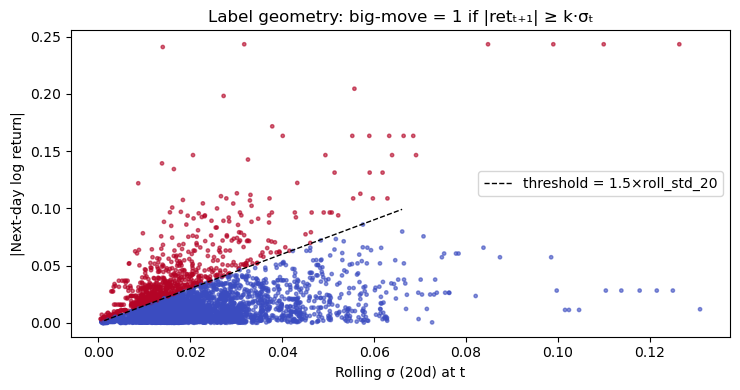

In [38]:

# ---------- Label geometry: |next-day return| vs threshold ----------
plt.figure(figsize=(7.5,4))
idx = np.random.RandomState(0).choice(len(dfm), size=min(5000, len(dfm)), replace=False)
plt.scatter(dfm.loc[idx,"roll_std_20"], dfm.loc[idx,"abs_ret_tp1"],
            s=6, c=dfm.loc[idx,"label_big_move"], cmap="coolwarm", alpha=0.6)
xline = np.linspace(dfm["roll_std_20"].quantile(0.01), dfm["roll_std_20"].quantile(0.99), 100)
plt.plot(xline, K_SIGMA*xline, "k--", lw=1, label=f"threshold = {K_SIGMA}×roll_std_20")
plt.xlabel("Rolling σ (20d) at t"); plt.ylabel("|Next-day log return|")
plt.title("Label geometry: big-move = 1 if |retₜ₊₁| ≥ k·σₜ")
plt.legend(); plt.tight_layout(); plt.show()


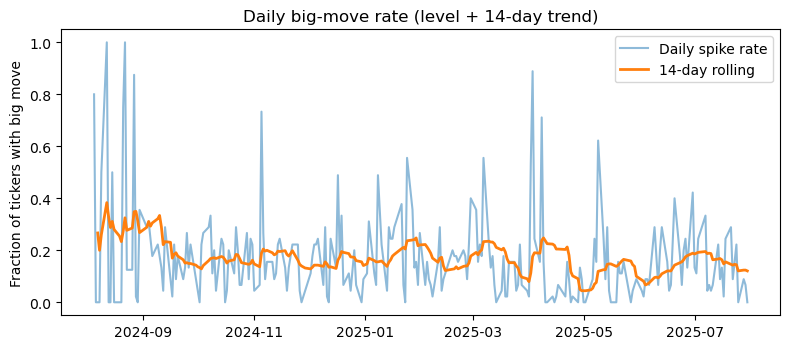

In [39]:

# -- Daily spike rate with rolling mean ----------
daily = (dfm.groupby("Date")["label_big_move"].mean()
           .rename("spike_rate").reset_index())
daily["spike_rate_roll"] = daily["spike_rate"].rolling(14, min_periods=3).mean()

plt.figure(figsize=(8,3.6))
plt.plot(daily["Date"], daily["spike_rate"], alpha=0.5, label="Daily spike rate")
plt.plot(daily["Date"], daily["spike_rate_roll"], lw=2, label="14-day rolling")
plt.ylabel("Fraction of tickers with big move")
plt.title("Daily big-move rate (level + 14-day trend)")
plt.legend(); plt.tight_layout(); plt.show()


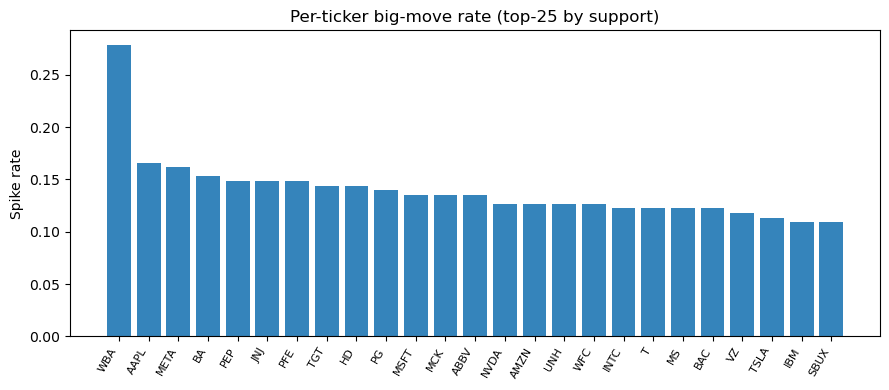

In [40]:

# - Per-ticker spike propensity (top 25 by support) ----------
supp = dfm.groupby("Ticker").size().rename("N")
rate = dfm.groupby("Ticker")["label_big_move"].mean().rename("SpikeRate")
per_ticker = (pd.concat([supp, rate], axis=1)
                .sort_values("N", ascending=False).head(25)
                .sort_values("SpikeRate", ascending=False))

plt.figure(figsize=(9,4))
plt.bar(per_ticker.index, per_ticker["SpikeRate"], alpha=0.9)
plt.xticks(rotation=60, ha="right", fontsize=8)
plt.ylabel("Spike rate"); plt.title("Per-ticker big-move rate (top-25 by support)")
plt.tight_layout(); plt.show()


In [41]:

# ----- Mentions vs spike rate  ----------
mention_cols = [c for c in ["all_keywords_mentions","ticker_mentions","ceo_mentions"] if c in dfm.columns]
mention_cols

['all_keywords_mentions', 'ticker_mentions', 'ceo_mentions']

In [42]:

for col in mention_cols:
    s = dfm[col].fillna(0)

    # if constant → skip (no meaningful bins)
    if s.nunique() <= 1:
        print(f"[skip] {col}: constant (nunique={s.nunique()})")
        continue

    # deciles; drop dup bins if distribution is discrete
    q = pd.qcut(s, q=10, duplicates="drop")
    # mean spike rate per bin
    by = dfm.groupby(q)["label_big_move"].mean()
    if by.empty:
        print(f"[skip] {col}: empty grouping after qcut()")
        continue

    # compute bin centers from the Interval index
    centers = by.index.map(lambda iv: 0.5*(iv.left + iv.right)).astype(float).to_numpy()
    yvals   = by.values

    # sort by centers in case qcut returned non-monotone categories
    order = centers.argsort()
    centers = centers[order]
    yvals   = yvals[order]

    plt.figure(figsize=(6.6, 3.2))
    plt.plot(centers, yvals, marker="o", lw=1.5)
    plt.xlabel(f"{col} (decile bin centers)")
    plt.ylabel("Spike rate (mean label)")
    plt.title(f"Spike rate vs {col} (deciles)")
    plt.tight_layout()
    plt.show()


[skip] all_keywords_mentions: constant (nunique=1)
[skip] ticker_mentions: constant (nunique=1)
[skip] ceo_mentions: constant (nunique=1)


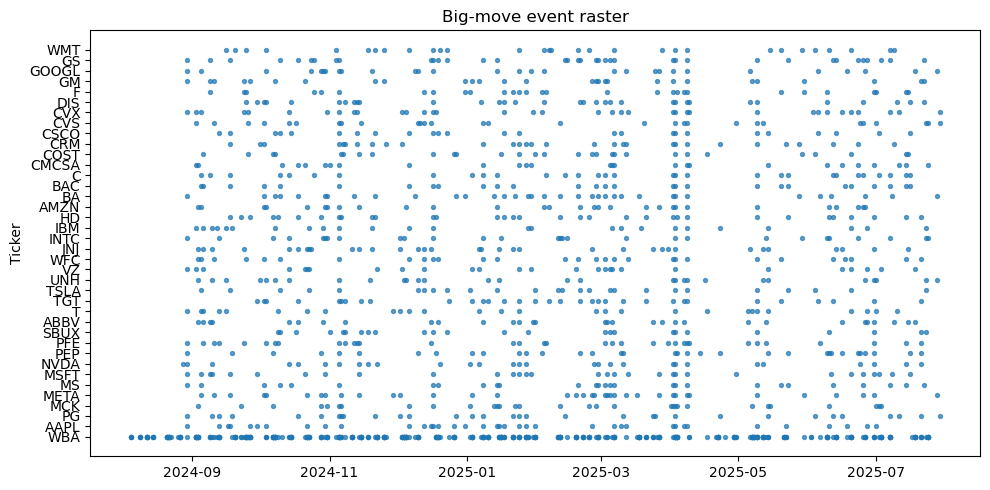

In [43]:

# ---Event raster (who spiked when?) ----------
topN = (dfm.groupby("Ticker").size().sort_values(ascending=False).index.tolist())
grid = dfm[dfm["Ticker"].isin(topN)][["Date","Ticker","label_big_move"]].copy()
grid["ypos"] = grid["Ticker"].map({t:i for i,t in enumerate(topN)})
plt.figure(figsize=(10,5))
d_spike = grid[grid["label_big_move"]==1]
plt.scatter(d_spike["Date"], d_spike["ypos"], s=8, alpha=0.7)
plt.yticks(range(len(topN)), topN); plt.ylabel("Ticker")
plt.title("Big-move event raster")
plt.tight_layout(); plt.show()


In [44]:

# ---Threshold sensitivity summary ----------
summary = (
    dfm.assign(thresh=K_SIGMA*dfm["roll_std_20"])
       .agg(Spikes=("label_big_move","sum"),
            Rows=("label_big_move","size"),
            SpikeRate=("label_big_move","mean"),
            MedianSigma=("roll_std_20","median"),
            MedianAbsRet=("abs_ret_tp1","median"))
)
print("Summary:", summary.to_dict())


Summary: {'label_big_move': {'Spikes': 1676.0, 'Rows': 10445.0, 'SpikeRate': 0.1604595500239349, 'MedianSigma': nan, 'MedianAbsRet': nan}, 'roll_std_20': {'Spikes': nan, 'Rows': nan, 'SpikeRate': nan, 'MedianSigma': 0.015837131722233087, 'MedianAbsRet': nan}, 'abs_ret_tp1': {'Spikes': nan, 'Rows': nan, 'SpikeRate': nan, 'MedianSigma': nan, 'MedianAbsRet': 0.0093923418663273}}
